# ML Random Forest

Purpose: this file uses the SAME training and testing set generated in 07_ml_randomForest.Rmd and trains a random forest model with down-sampling. This result will be used to compare to the R version.

NOTE: the training and testing sets already excluded ID, patient_ID columns and only kept non "Review" Evaluations as in the following pre-processing: 

df_ml_no_review <- df_ml %>% 
  filter(Evaluation != "Review") %>% 
  mutate(Evaluation = ifelse(Evaluation == "Accept", 1, 0)) %>%
  mutate(Evaluation = factor(Evaluation, levels = 0:1, labels = c("Reject", "Accept"))) #%>%
  #mutate(across(where(is.numeric), scale)) # Scale the numeric predictors 

In [31]:
import os
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.utils import resample
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib


In [32]:
# Set the working directory
project_dir = Path("/Users/Jennie/Desktop/WashU/Rotation_labs/Griffith Lab/Neoantigen ML project")
os.chdir(project_dir)

# Define output directory
outdir = project_dir / "output_python" / "07_ml_randomForest.ipynb"
os.makedirs(outdir, exist_ok=True)
print(f"Output directory created at: {outdir}")


Output directory created at: /Users/Jennie/Desktop/WashU/Rotation_labs/Griffith Lab/Neoantigen ML project/output_python/07_ml_randomForest.ipynb


Import training and testing data from R

In [33]:
# Load training and testing data
train_data = pd.read_csv(project_dir / "output" / "07_ml_randomForest.Rmd" / "rf_train.csv")
test_data = pd.read_csv(project_dir / "output" / "07_ml_randomForest.Rmd" / "rf_test.csv")

# Check the data
print(train_data.head())
print(test_data.head())

#train_data.columns.tolist()
#train_data.describe()


  Evaluation  TSL  Pos  Prob.Pos  Num.Passing.Peptides  RNA.Expr  RNA.VAF  \
0     Reject    1    1         4                     3     9.651    0.120   
1     Reject    5    3         0                     9     0.000    0.000   
2     Reject    1    6         0                     1    31.961    0.003   
3     Reject    6    1         1                     0    25.819    0.000   
4     Reject    1    3         0                     1     2.392    0.208   

   Allele.Expr  RNA.Depth  DNA.VAF  ...  SMM.WT.IC50.Score SMM.MT.IC50.Score  \
0        1.158       25.0    0.105  ...        2632.940000        586.280000   
1        0.000        0.0    0.264  ...         108.300385        164.297139   
2        0.096     1114.0    0.137  ...        1113.140540        973.979912   
3        0.000        2.0    0.075  ...          17.667293         76.589635   
4        0.498       24.0    0.246  ...          32.801220        194.039434   

  SMM.WT.Percentile  SMM.MT.Percentile  SMMPMBEC.WT.IC50

In [34]:
# Step 1: Identify categorical columns EXCEPT the label
categorical_cols = train_data.select_dtypes(include=['object', 'category']).columns.drop('Evaluation')
print("Categorical columns:", categorical_cols)

# Step 2: Label encode features only
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    train_data[col] = le.fit_transform(train_data[col])
    test_data[col] = le.transform(test_data[col])
    label_encoders[col] = le

# Step 3: Manually encode 'Evaluation' with Accept = 1, Reject = 0
# Explicit mapping: Accept = 1, Reject = 0
label_map = {'Accept': 1, 'Reject': 0}

train_data['Evaluation'] = train_data['Evaluation'].map(label_map)
test_data['Evaluation'] = test_data['Evaluation'].map(label_map)

# Optional: store this mapping
label_encoders['Evaluation'] = label_map

for col, le in label_encoders.items():
    print(f"Mapping for {col}:")
    if isinstance(le, LabelEncoder):
        for class_index, class_label in enumerate(le.classes_):
            print(f"  {class_label} -> {class_index}")
    elif isinstance(le, dict):
        for class_label, class_index in le.items():
            print(f"  {class_label} -> {class_index}")

# Save the label encoders to a file
joblib.dump(label_encoders, project_dir / "output_python" / "07_ml_randomForest.ipynb" / "label_encoders.pkl")            

# Manual tracking
label_map = {'Accept': 1, 'Reject': 0}
reverse_map = {v: k for k, v in label_map.items()}

# Separate features and target for training data
X_train_encoded = train_data.drop(columns=['Evaluation'])
y_train = train_data['Evaluation']

# Separate features and target for testing data
X_test_encoded = test_data.drop(columns=['Evaluation'])
y_test = test_data['Evaluation']


Categorical columns: Index(['Biotype', 'Variant.Type', 'Prob.match', 'driver_gene'], dtype='object')
Mapping for Biotype:
  IG_V_gene -> 0
  nonsense_mediated_decay -> 1
  protein_coding -> 2
Mapping for Variant.Type:
  FS -> 0
  inframe_del -> 1
  inframe_ins -> 2
  missense -> 3
Mapping for Prob.match:
  NO -> 0
  YES -> 1
Mapping for driver_gene:
  NO -> 0
  YES -> 1
Mapping for Evaluation:
  Accept -> 1
  Reject -> 0


## Tune Random Forest
To perform down-sampling and tune the Random Forest model using GridSearchCV in Python, we can follow these steps:

1. Down-sample the majority class for each tree.
2. Tune the mtry (max_features) and ntree (n_estimators) using GridSearchCV.


The `BalancedRandomForestClassifier`: 
a classifier from the imblearn (imbalanced-learn) library, which is designed to handle imbalanced datasets. It is an extension of the traditional RandomForestClassifier that incorporates techniques to address class imbalance during the training process.

How BalancedRandomForestClassifier Works
Bootstrap Sampling with Replacement: For each tree in the forest, BalancedRandomForestClassifier performs bootstrap sampling with replacement. This means that it randomly selects samples from the training dataset to create a new dataset for training each tree.

Class Balancing: During the bootstrap sampling process, BalancedRandomForestClassifier ensures that each class is equally represented. It does this by **down-sampling** the majority class so that each class has the same number of samples. This helps to mitigate the bias towards the majority class that can occur in traditional random forests.

Out-of-Bag (OOB) Estimation: The classifier supports out-of-bag (OOB) estimation, which is a method for evaluating the performance of the model without the need for a separate validation set. OOB estimation uses the samples that were not selected during the bootstrap sampling process to evaluate the model's performance.

Key Parameters
`n_estimators`: The number of trees in the forest.
`max_features`: The number of features to consider when looking for the best split.
`oob_score`: Whether to use out-of-bag samples to estimate the generalization accuracy.
`random_state`: Controls the randomness of the bootstrap sampling and feature selection.
`n_jobs`: The number of jobs to run in parallel. -1 means using all processors.
`replacement`: Whether to sample with replacement. For BalancedRandomForestClassifier, this is typically set to True.
`bootstrap`: Whether bootstrap samples are used when building trees. This should be set to True for OOB estimation.

In [35]:
# Read the best mtry and ntree 
# Define paths to the saved parameters
best_mtry_path = project_dir / "output_python" / "07_ml_randomForest.ipynb" / "best_mtry_rf.pkl"
best_ntree_path = project_dir / "output_python" / "07_ml_randomForest.ipynb" / "best_ntree_rf.pkl"


best_mtry = joblib.load(best_mtry_path)
best_ntree = joblib.load(best_ntree_path)
print(f"Loaded best max_features (mtry): {best_mtry}")
print(f"Loaded best n_estimators (ntree): {best_ntree}")


Loaded best max_features (mtry): 50
Loaded best n_estimators (ntree): 101


## Training
Use the tuned best mtry and ntree, train RF model

In [36]:
# Train the final Random Forest model
rf = BalancedRandomForestClassifier(
    n_estimators=best_ntree,
    max_features=best_mtry,
    oob_score=True, 
    random_state=42,
    n_jobs=-1,
    replacement=True,
    bootstrap=True  # Set bootstrap=True for OOB estimation
)
rf.fit(X_train_encoded, y_train)

# Save the trained model
joblib.dump(rf, project_dir / "output_python" / "07_ml_randomForest.ipynb" / "rf_model.pkl")


['/Users/Jennie/Desktop/WashU/Rotation_labs/Griffith Lab/Neoantigen ML project/output_python/07_ml_randomForest.ipynb/rf_model.pkl']

### OOB evaluation

OOB Error: 0.07650862068965514
OOB Confusion Matrix:
[[647  65]
 [  6 210]]
Sensitivity (Recall or True Positive Rate): 0.9722222222222222
Specificity (True Negative Rate): 0.9087078651685393


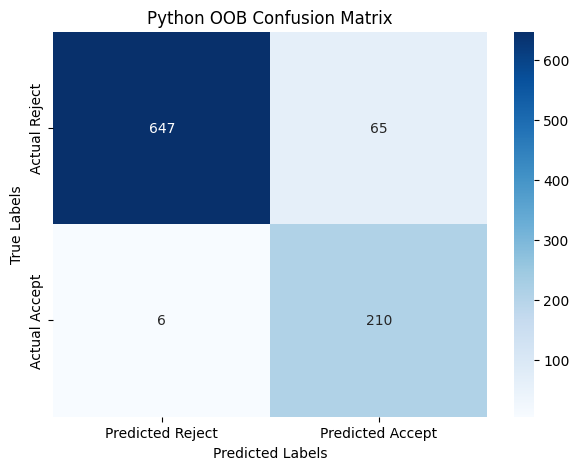

OOB ROC AUC: 0.9779409852267997


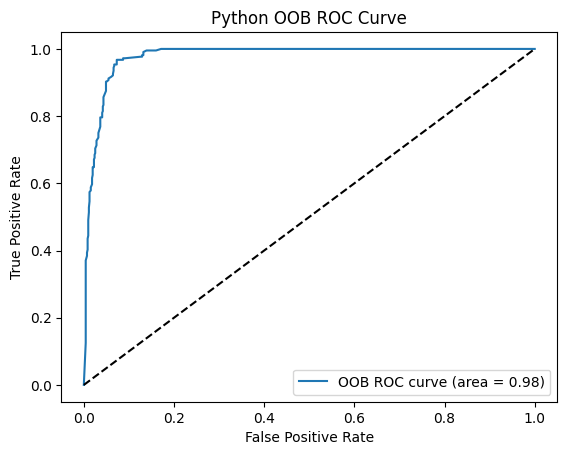

In [37]:
# Evaluate the model
oob_error = 1 - rf.oob_score_
print(f"OOB Error: {oob_error}") # the proportion of misclassified samples among the OOB samples.

# extract the OOB predictions
oob_predictions = rf.oob_decision_function_[:, 1] > 0.5 
# each row corresponds to a sample and each column corresponds to the class probabilities. 
# The first column ([:, 0]) gives the probability of the negative class ("Reject" in our case since it is mapped to 0).
# The second column ([:, 1]) gives the probability of the positive class ("Accept" in our case since it is mapped to 1).
# "True" for predicted as "Reject"

# Convert boolean predictions to integers
oob_predictions_int = oob_predictions.astype(int) # change True to 1 and False to 0 (0: Reject, 1: Accept)

# Calculate the confusion matrix
oob_conf_matrix = confusion_matrix(y_train, oob_predictions_int)
# The confusion matrix is a 2x2 matrix with the following structure:
# [[TN, FP],
# [FN, TP]]

print("OOB Confusion Matrix:")
print(oob_conf_matrix)

# Extract TN, FP, FN, TP from the confusion matrix
TN, FP, FN, TP = oob_conf_matrix.ravel()

# Calculate sensitivity and specificity
oob_sensitivity = TP / (TP + FN)
oob_specificity = TN / (TN + FP)

print(f"Sensitivity (Recall or True Positive Rate): {oob_sensitivity}")
print(f"Specificity (True Negative Rate): {oob_specificity}")

# Plot the confusion matrix with labels
plt.figure(figsize=(7, 5))
sns.heatmap(oob_conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Reject', 'Predicted Accept'], # column names
            yticklabels=['Actual Reject', 'Actual Accept']) # row names
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Python OOB Confusion Matrix')
plt.savefig(project_dir / "output_python" / "07_ml_randomForest.ipynb" / "oob_conf_matrix.png")
plt.show()

# Calculate OOB ROC AUC
oob_roc_auc = roc_auc_score(y_train, rf.oob_decision_function_[:, 1])
print(f"OOB ROC AUC: {oob_roc_auc}")

# Plot OOB ROC curve
fpr, tpr, _ = roc_curve(y_train, rf.oob_decision_function_[:, 1])
plt.plot(fpr, tpr, label=f'OOB ROC curve (area = {oob_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Python OOB ROC Curve')
plt.legend(loc='best')
plt.savefig(project_dir / "output_python" / "07_ml_randomForest.ipynb" / "oob_roc_curve.png")
plt.show()



# Predict on test set

Test Set Confusion Matrix:
[[195  33]
 [  8  73]]
Test Set Accuracy: 0.8673139158576052
Sensitivity (Recall or True Positive Rate): 0.9012345679012346
Specificity (True Negative Rate): 0.8552631578947368
Test Set ROC AUC: 0.9326943902967294


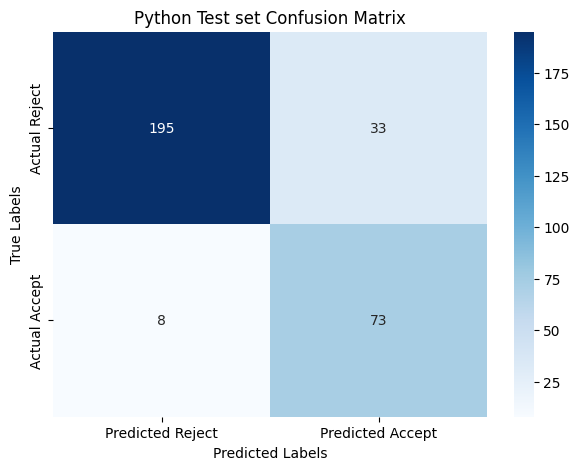

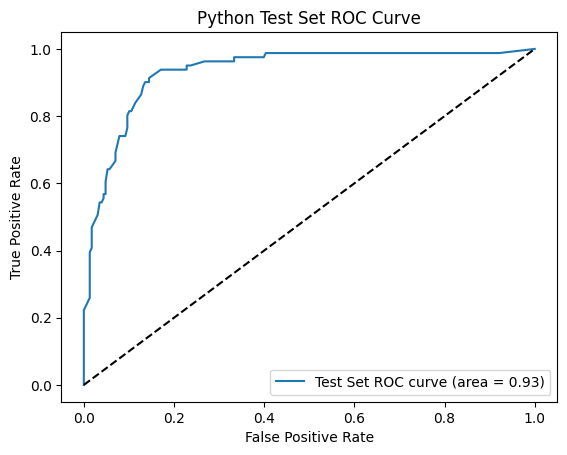

In [38]:
# Predict on test set
rf_pred = rf.predict(X_test_encoded)

rf_conf_matrix = confusion_matrix(y_test, rf_pred)
print("Test Set Confusion Matrix:")
print(rf_conf_matrix)

rf_pred_accuracy = accuracy_score(y_test, rf_pred)
print(f"Test Set Accuracy: {rf_pred_accuracy}")

# Extract TN, FP, FN, TP from the confusion matrix and convert to standard Python integers
TN, FP, FN, TP = [int(x) for x in rf_conf_matrix.ravel()]

# Calculate sensitivity and specificity
rf_sensitivity = TP / (TP + FN)
rf_specificity = TN / (TN + FP)

print(f"Sensitivity (Recall or True Positive Rate): {rf_sensitivity}")
print(f"Specificity (True Negative Rate): {rf_specificity}")


rf_pred_prob = rf.predict_proba(X_test_encoded)[:, 1]
rf_roc_auc = roc_auc_score(y_test, rf_pred_prob)
print(f"Test Set ROC AUC: {rf_roc_auc}")

plt.figure(figsize=(7, 5))
sns.heatmap(rf_conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Reject', 'Predicted Accept'], # column names
            yticklabels=['Actual Reject', 'Actual Accept']) # row names
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Python Test set Confusion Matrix')
plt.savefig(project_dir / "output_python" / "07_ml_randomForest.ipynb" / "test_conf_matrix.png")
plt.show()


fpr, tpr, _ = roc_curve(y_test, rf_pred_prob)
plt.plot(fpr, tpr, label=f'Test Set ROC curve (area = {rf_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Python Test Set ROC Curve')
plt.legend(loc='best')
plt.savefig(project_dir / "output_python" / "07_ml_randomForest.ipynb" / "test_set_roc_curve.png")
plt.show()



## Variable of importance
In scikit-learn's RandomForestClassifier, the feature importance is computed as:

**Mean Decrease in Impurity (MDI)**: The total reduction in impurity (weighted by the number of samples passing through the split) for each feature, averaged across all trees in the forest.
The feature importance values are normalized so that they sum to 1.

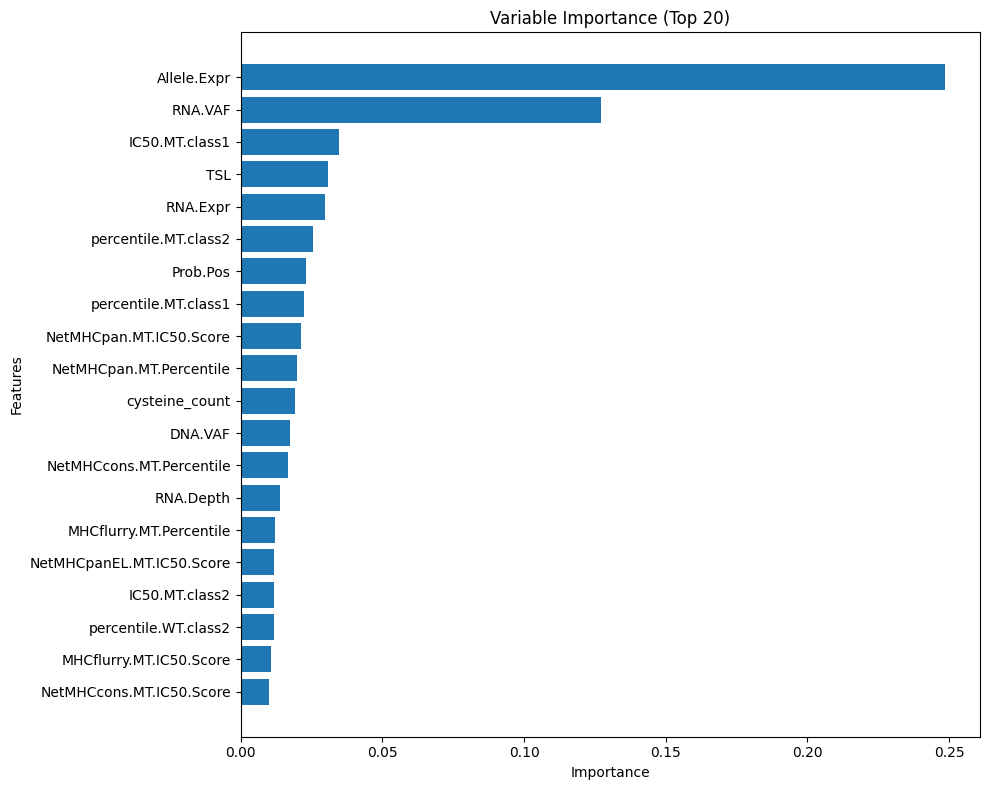

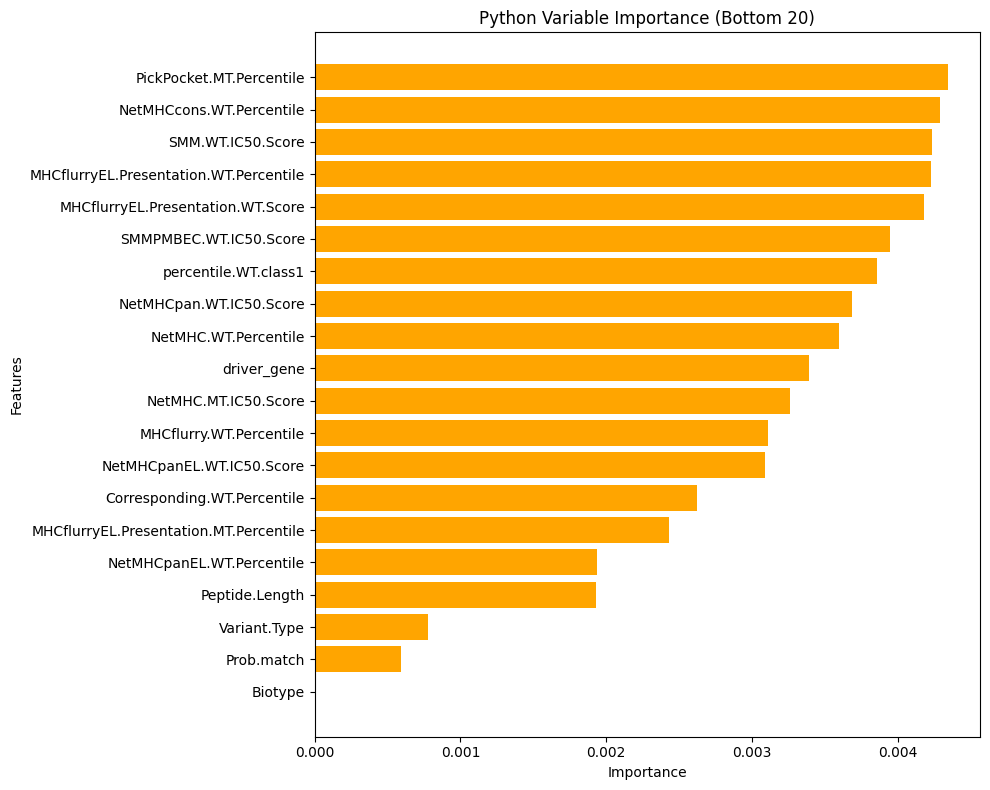

In [ ]:
# Variable importance
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
features = X_train_encoded.columns

# Plot the top 20 variable importance with flipped axes
plt.figure(figsize=(10, 8))
plt.title("Python Model Variable Importance (Top 20)")
plt.barh(range(20), importances[indices[:20]], align="center")
plt.yticks(range(20), features[indices[:20]])
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.xlabel('Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.savefig(project_dir / "output_python" / "07_ml_randomForest.ipynb" / "variable_importance_top_20.png")
plt.show()

# Plot the bottom 20 variable importance with flipped axes
plt.figure(figsize=(10, 8))
plt.title("Python Model Variable Importance (Bottom 20)")
plt.barh(range(20), importances[indices[-20:]], align="center", color="orange")  # Set bar color to orange
plt.yticks(range(20), features[indices[-20:]])
plt.gca().invert_yaxis()  # Invert y-axis to have the least important feature at the top
plt.xlabel('Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.savefig(project_dir / "output_python" / "07_ml_randomForest.ipynb" / "variable_importance_bottom_20.png")
plt.show()
